In [166]:
import pysam
import pandas as pd
import matplotlib.pyplot as plt

In [167]:
fetch_df = pd.read_csv('interesting_genes.bed', sep='\t', header=None, names=['chr', 'start', 'stop', 'gene'])

In [168]:
fetch_df

,chr,start,stop,gene
0,chr17,39688094,39728658,ERBB2
1,chr17,43044295,43170327,BRCA1
2,chr13,32315508,32400268,BRCA2
3,chr11,125625136,125681124,CHEK1
4,chr22,28687743,28741834,CHEK2
5,chr7,55019017,55211628,EGFR
6,chr8,38411143,38468635,FGFR1
7,chr10,121478330,121598458,FGFR2
8,chr4,1793293,1808867,FGFR3
9,chr7,116672196,116798377,MET


In [169]:
#pysam.index("../WES-normal.bam")

In [170]:
samfile = pysam.AlignmentFile('../WES-normal.bam', 'rb')
genes_bam = pysam.AlignmentFile('../genes.bam', 'wb', template=samfile)

i = 0
d = []

for index, gene in fetch_df.iterrows():
    print(gene['gene'])
    for read in samfile.fetch(gene['chr'], gene['start'], gene['stop']):
        genes_bam.write(read)
        if i < 21:
            #print(read)
            i+=1
    for pileupcolumn in samfile.pileup(gene['chr'], gene['start'], gene['stop']):
        d.append(
                {
                    'Position': pileupcolumn.pos,
                    'Read Count': pileupcolumn.n,
                    'Chromosome': gene['chr'],
                    'Gene': gene['gene']
                }
            )

df_normal = pd.DataFrame(d)


genes_bam.close()
samfile.close()

ERBB2
BRCA1
BRCA2
CHEK1
CHEK2
EGFR
FGFR1
FGFR2
FGFR3
MET
MTAP
MDM2
NF1
NTRK1
PALB2
RB1
STK11
TSC1
TSC2
TP53
CDKN2A


In [171]:
df_normal

,Position,Read Count,Chromosome,Gene
0,39687957,1,chr17,ERBB2
1,39687958,1,chr17,ERBB2
2,39687959,1,chr17,ERBB2
3,39687960,1,chr17,ERBB2
4,39687961,1,chr17,ERBB2
...,...,...,...,...
988693,21995383,2,chr9,CDKN2A
988694,21995384,2,chr9,CDKN2A
988695,21995385,2,chr9,CDKN2A
988696,21995386,2,chr9,CDKN2A


In [172]:
#pysam.index("../WES-tumor.bam")

In [173]:
samfile = pysam.AlignmentFile('../WES-tumor.bam', 'rb')
genes_bam = pysam.AlignmentFile('../genes_tumor.bam', 'wb', template=samfile)

i = 0
d = []

for index, gene in fetch_df.iterrows():
    print(gene['gene'])
    for read in samfile.fetch(gene['chr'], gene['start'], gene['stop']):
        genes_bam.write(read)

        ############
        if i < 21:
            #print(read)
            i+=1

    #############
    
    for pileupcolumn in samfile.pileup(gene['chr'], gene['start'], gene['stop']):
            d.append(
                {
                    'Position': pileupcolumn.pos,
                    'Read Count': pileupcolumn.n,
                    'Chromosome': gene['chr'],
                    'Gene': gene['gene']
                }
            )

df_tumor = pd.DataFrame(d)

genes_bam.close()
samfile.close()

ERBB2
BRCA1
BRCA2
CHEK1
CHEK2
EGFR
FGFR1
FGFR2
FGFR3
MET
MTAP
MDM2
NF1
NTRK1
PALB2
RB1
STK11
TSC1
TSC2
TP53
CDKN2A


In [174]:
df_tumor

,Position,Read Count,Chromosome,Gene
0,39687955,4,chr17,ERBB2
1,39687956,4,chr17,ERBB2
2,39687957,7,chr17,ERBB2
3,39687958,9,chr17,ERBB2
4,39687959,9,chr17,ERBB2
...,...,...,...,...
965358,21995451,2,chr9,CDKN2A
965359,21995452,2,chr9,CDKN2A
965360,21995453,2,chr9,CDKN2A
965361,21995454,2,chr9,CDKN2A


In [175]:
df_tumor.pivot_table(columns=['Position'], aggfunc='size')[df_tumor.pivot_table(columns=['Position'], aggfunc='size')>1]

Series([], dtype: int64)

In [176]:
df_tumor[df_tumor['Position'] == 39687957]

,Position,Read Count,Chromosome,Gene
2,39687957,7,chr17,ERBB2


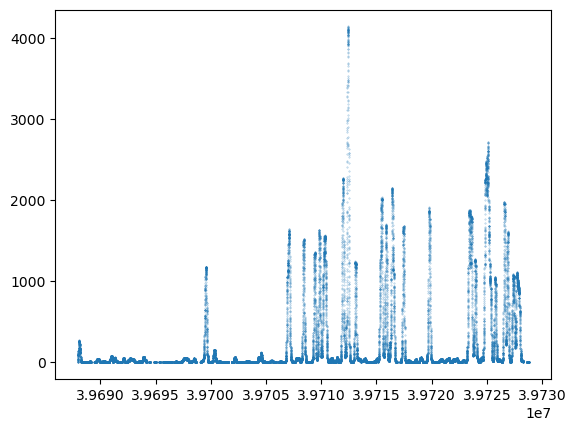

In [177]:
plt.scatter(df_tumor[df_tumor['Gene'] == 'ERBB2']['Position'], df_tumor[df_tumor['Gene'] == 'ERBB2']['Read Count'], alpha=0.5, s=0.1)

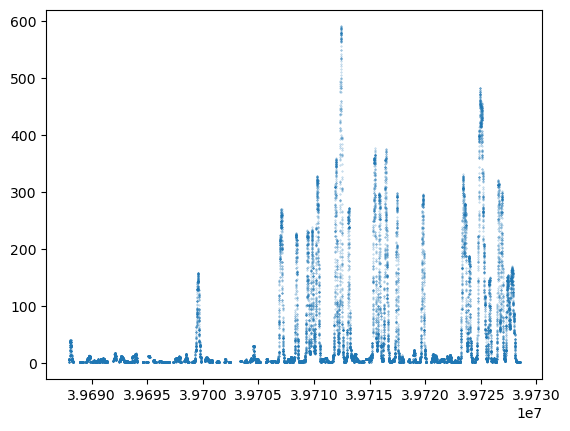

In [178]:
plt.scatter(df_normal[df_normal['Gene'] == 'ERBB2']['Position'], df_normal[df_normal['Gene'] == 'ERBB2']['Read Count'], alpha=0.5, s=0.1)

In [179]:
df_total = df_tumor.merge(df_normal, left_on='Position', right_on='Position',
          suffixes=('_tumor', '_normal'), how='outer')

In [180]:
df_total

,Position,Read Count_tumor,Chromosome_tumor,Gene_tumor,Read Count_normal,Chromosome_normal,Gene_normal
0,39687955,4.0,chr17,ERBB2,NaN,NaN,NaN
1,39687956,4.0,chr17,ERBB2,NaN,NaN,NaN
2,39687957,7.0,chr17,ERBB2,1.0,chr17,ERBB2
3,39687958,9.0,chr17,ERBB2,1.0,chr17,ERBB2
4,39687959,9.0,chr17,ERBB2,1.0,chr17,ERBB2
...,...,...,...,...,...,...,...
1231399,21995185,NaN,NaN,NaN,2.0,chr9,CDKN2A
1231400,21995186,NaN,NaN,NaN,2.0,chr9,CDKN2A
1231401,21995187,NaN,NaN,NaN,2.0,chr9,CDKN2A
1231402,21995188,NaN,NaN,NaN,2.0,chr9,CDKN2A


In [181]:
df_dupl = df_total.pivot_table(columns=['Position'], aggfunc='size')

In [182]:
df_dupl[df_dupl > 1]

Series([], dtype: int64)

In [184]:
df_total['depth_ratio'] = df_total['Read Count_tumor'] / df_total['Read Count_normal']

In [185]:
df_total

,Position,Read Count_tumor,Chromosome_tumor,Gene_tumor,Read Count_normal,Chromosome_normal,Gene_normal,depth_ratio
0,39687955,4.0,chr17,ERBB2,NaN,NaN,NaN,NaN
1,39687956,4.0,chr17,ERBB2,NaN,NaN,NaN,NaN
2,39687957,7.0,chr17,ERBB2,1.0,chr17,ERBB2,7.0
3,39687958,9.0,chr17,ERBB2,1.0,chr17,ERBB2,9.0
4,39687959,9.0,chr17,ERBB2,1.0,chr17,ERBB2,9.0
...,...,...,...,...,...,...,...,...
1231399,21995185,NaN,NaN,NaN,2.0,chr9,CDKN2A,NaN
1231400,21995186,NaN,NaN,NaN,2.0,chr9,CDKN2A,NaN
1231401,21995187,NaN,NaN,NaN,2.0,chr9,CDKN2A,NaN
1231402,21995188,NaN,NaN,NaN,2.0,chr9,CDKN2A,NaN


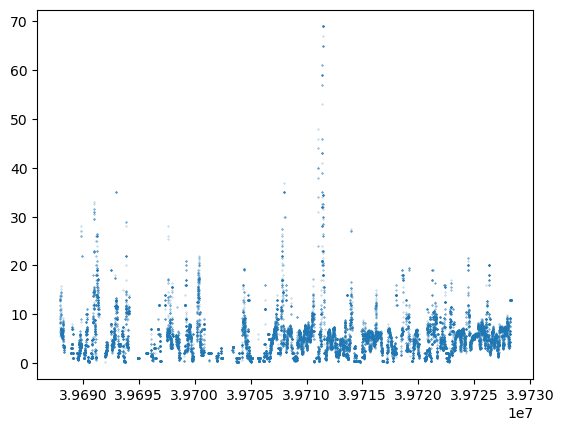

In [188]:
plt.scatter(df_total[df_total['Gene_tumor'] == 'ERBB2']['Position'], df_total[df_total['Gene_tumor'] == 'ERBB2']['depth_ratio'], alpha=0.5, s=0.1)